In [1]:
from rubin_sim.scheduler.modelObservatory import Model_observatory
from rubin_sim.scheduler.surveys import BaseSurvey, Scripted_survey
from rubin_sim.scheduler.utils import empty_observation, scheduled_observation
from rubin_sim.scheduler.schedulers import Core_scheduler, simple_filter_sched
from rubin_sim.scheduler import sim_runner

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

In [2]:
# load up a model observatory.
nside=32  # Specify the HEALpix resolution we want to do everything in.
mo = Model_observatory(nside=nside)

In [3]:
conditions = mo.return_conditions()

In [4]:
conditions.mjd

60218.0

In [5]:
# Let's make a few observations manually, then load them into a scripted survey object
obs = scheduled_observation(10)
obs['RA'] = 0
obs['dec'] = np.radians(-90.)
# Set them to be every 30 minutes, starting 2 hours from current mjd
obs['mjd'] = conditions.mjd + np.arange(10)*0.5/24 + 2./24.
obs['exptime'] = 30
obs['nexp'] = 2
obs['filter'] = 'i'
obs['note'] = 'scripted'

# This is a little tichy. Need to set these, 
# Otherwise they will not pass tests and get served up
obs['flush_by_mjd'] = conditions.mjd + 10
# Now some extra fields that need to be set
obs['mjd_tol'] = 10./3600/24.
obs['dist_tol'] = np.radians(3.)
obs['alt_min'] = 0
obs['alt_max'] = np.radians(85.)
# This is effectively no hour angle limit. XXX--need to document better
obs['HA_max'] = 0. # Hours
obs['HA_min'] = 24.

# You can make this list of scheduled observations any way you like! Can be one observations, or lots over years.

In [6]:
ss = Scripted_survey([])
ss.set_script(obs)

In [7]:
# Our friend the SCP survey from before
class SCP_survey(BaseSurvey):
    """A South Celestial Pole survey"""
    def generate_observations_rough(self, conditions):
        obs = empty_observation()
        obs['RA'] = 0.
        obs['dec'] = np.radians(-87.)
        obs['exptime'] = 30.
        obs['nexp'] = 2
        obs['filter'] = 'r'
        # If it's been 12 hours or more, don't try to execute the observation anymore
        obs['flush_by_mjd'] = conditions.mjd + 0.5
        obs['note'] = 'scp'  # Always good to set the note to which survey generated the observation
        result = [obs] * 3
        return result

In [8]:
scp = SCP_survey([])

In [9]:
# Now, we can run both surveys at the same time. 
scheduler = Core_scheduler([[ss], [scp]], nside=nside)


In [10]:
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=1.0,
                                                 verbose=True)

progress = 98.37%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:410: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 914 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [11]:
# Wow, note now we have 914 observations. Down from 979 before. That's what 10 filter changes in a night will do.
np.unique(observations['note'])

array(['scp', 'scripted'], dtype='<U40')

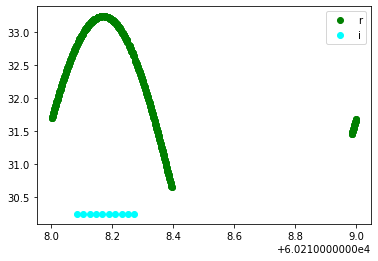

In [12]:
# let's plot and color-code by filter
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()

In [14]:
# Keep in mind, that mjd_tol is a tricky paramter. If you make it very large, your
# observation might execute earlier than you like. Set it small, and your background survey
# might take too much time and box it out. 

In [ ]:
# Note on survey objects. 1-10s of survey objects are fine. (baseline currently has 17 survey objects). But 
# the code is not designed to scale up to thousands of survey objects. If you are tempted to generate
# a decision tree with thoudands of survey objects there's probably a better way to do it.